In [1]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.stats as stats
import pandas as pd
from matplotlib import scale as mscale
from matplotlib import transforms as mtransforms
from matplotlib.ticker import Formatter, FixedLocator
from matplotlib.patches import Rectangle

In [2]:
# Set up PPF scale for CDF plots
class PPFScale(mscale.ScaleBase):
    name = "ppf"

    def __init__(self, axis, **kwargs):
        mscale.ScaleBase.__init__(self, axis)

    def get_transform(self):
        return self.PPFTransform()

    def set_default_locators_and_formatters(self, axis):
        class VarFormatter(Formatter):
            def __call__(self, x, pos=None):
                return f"{x}"[1:]

        axis.set_major_locator(FixedLocator(np.array([0,.0001,.001,.01,.1,.2,.3,.4,.5,.6,.7,.8,.9,.99,.999,.9999,1])))
        axis.set_major_formatter(VarFormatter())


    def limit_range_for_scale(self, vmin, vmax, minpos):
        return max(vmin, 1e-6), min(vmax, 1-1e-6)

    class PPFTransform(mtransforms.Transform):
        input_dims = output_dims = 1

        def ___init__(self, thresh):
            mtransforms.Transform.__init__(self)

        def transform_non_affine(self, a):
            return stats.norm.ppf(a)

        def inverted(self):
            return PPFScale.IPPFTransform()

    class IPPFTransform(mtransforms.Transform):
        input_dims = output_dims = 1

        def transform_non_affine(self, a):
            return stats.norm.cdf(a)

        def inverted(self):
            return PPFScale.PPFTransform()

# Register PPF scale
mscale.register_scale(PPFScale)

# Set up fonts
plt.rcParams["font.family"] = "arial"
plt.rcParams["font.size"] = 12

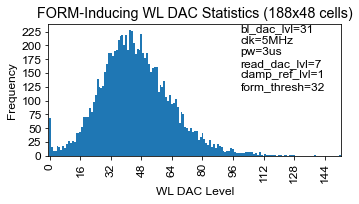

In [3]:
# Load log file
names = ["chip", "time", "addr", "operation", "mask", "wl_dac_lvl", "bsl_dac_lvl", "sa_do"]
formdata = pd.read_csv("../data/form.5mhz.188cell.csv", names=names, index_col=False)
formdata.sa_do = formdata.sa_do.shift(-1, fill_value=0)
formdata["nform"] = formdata.sa_do.apply(lambda di: bin(di).count("1"))
formdata = formdata[formdata.operation == "SET"]

# Figure
plt.figure(figsize=(5,3))
formdata[formdata.operation == "SET"].groupby("wl_dac_lvl").sum()["nform"].plot.bar(width=1)
plt.title("FORM-Inducing WL DAC Statistics (188x48 cells)")
plt.xlabel("WL DAC Level")
plt.ylabel("Frequency")
plt.text(100, 120, "bl_dac_lvl=31\nclk=5MHz\npw=3us\nread_dac_lvl=7\nclamp_ref_lvl=1\nform_thresh=32")
plt.locator_params(nbins=10)
plt.tight_layout()
plt.savefig("figs/form.wl.stats.pdf")

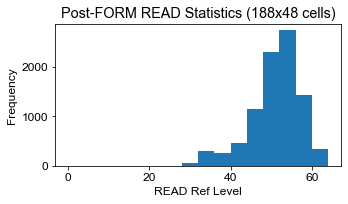

In [4]:
# Load log file
names = ["addr", "time"] + ["read_" + str(i) for i in range(48)]
formreaddata = pd.read_csv("../data/formread.5mhz.188cell.csv", names=names, index_col=False, delimiter="\t")

# Figure
plt.figure(figsize=(5,3))
plt.bar(np.arange(2, 64, 4), np.bincount(formreaddata[formreaddata.columns[-48:]].values.flatten()), width=4)
plt.title("Post-FORM READ Statistics (188x48 cells)")
plt.xlabel("READ Ref Level")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("figs/form.read.stats.pdf")

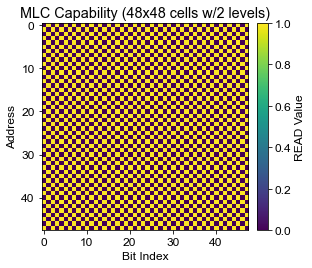

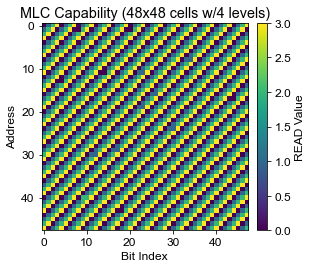

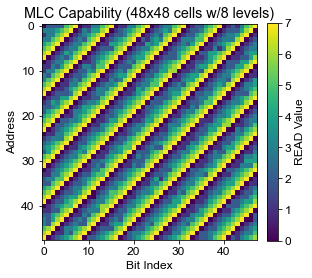

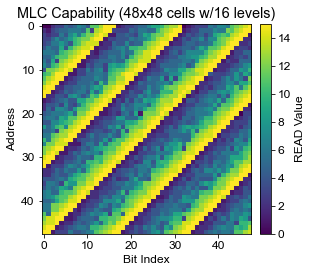

In [5]:
# Produce checkerboard plots for 1-4 bpc
for bpc in range(1, 5):
  # Load data
  names = ["addr", "time"] + ["read_" + str(i) for i in range(48)]
  data = pd.read_csv(f"../data/{'cb' if bpc==4 else ''}{bpc}bpc.csv", sep="\t", names=names)

  # Show multi-bit result
  plt.rcParams["figure.figsize"] = (4.5,4.5)
  plt.rcParams["font.family"] = "arial"
  plt.rcParams["font.size"] = 12
  matdata = data[data.columns[-48:]].values[-48:]
  im = plt.imshow(matdata, vmin=0, vmax=2**bpc-1)
  cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
  cbar.set_label("READ Value")
  plt.title(f"MLC Capability (48x48 cells w/{2**bpc} levels)")
  plt.xlabel("Bit Index")
  plt.ylabel("Address")
  plt.tight_layout()
  plt.savefig(f"figs/cb{bpc}bpc.pdf")
  plt.show()